# 환경 설정 및 모델 초기화

In [4]:
import os
import base64
import io
import json
from tqdm import tqdm
from PIL import Image
from dotenv import load_dotenv
from openai import OpenAI
import torch
from diffusers import StableDiffusionPipeline
from rembg import remove
from ip_adapter import IPAdapter

# --------------- 환경 설정 및 모델 초기화 -----------------
load_dotenv()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

# 유틸 함수

In [2]:
# ---------------유틸 함수 -----------------
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def remove_background(image_path):
    with open(image_path, 'rb') as f:
        input_data = f.read()
    output_data = remove(input_data)
    return Image.open(io.BytesIO(output_data))

## 모델 로드

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    force_download=True  # 중요!
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [182]:
prompt = (
    "a single food advertisement sample image for ice cream in black seramic bowl, low: food, high: square box, fire in the background"
)
negative_prompt = "food, human, logo, text"

  2%|▏         | 1/50 [00:00<00:05,  8.31it/s]

100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


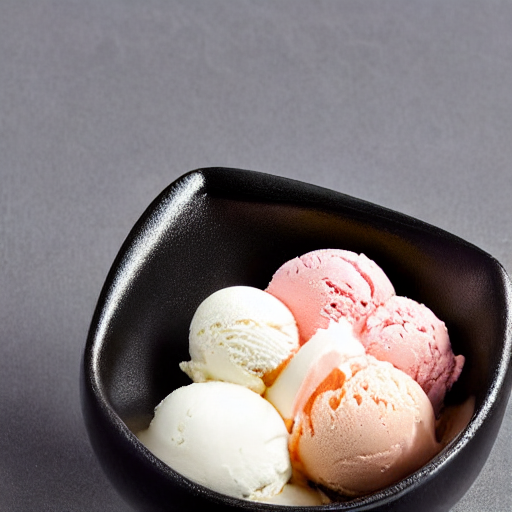

In [183]:
sample_gen = pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt
    )
sample_gen.images[0]

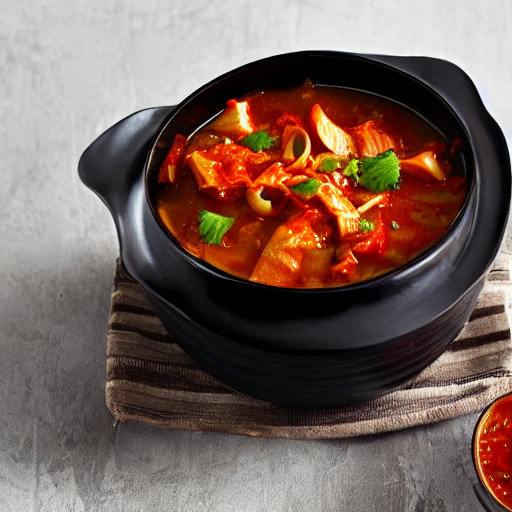

In [147]:
sample_gen.images[0]

In [4]:
ip_adapter = IPAdapter(
    pipe,
    image_encoder_path="laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    ip_ckpt="ip-adapter_sd15.bin",
    device=device
)


## 이미지 로드

In [70]:
product_image_path = "./images/food1.jfif"
reference_image_path = './images/image.png'

## 이미지 분석 프롬프트 정리

In [6]:
prompt = (
    "You are advertisement banner creater. "
    "Use given image as target image and create a advertisement poster. "
    "Put the target image bottom-left with suitable dish and make a room for ad banner on top"
)

In [7]:
negative_prompt = (
    "blurry, text artifacts, low resolution, extra fingers, distorted layout, watermark, "
    "bad anatomy, overexposed, logo error, low contrast"
)

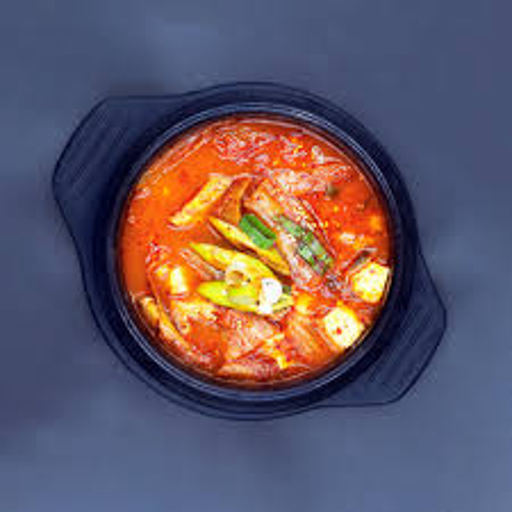

In [8]:
input_image = Image.open(product_image_path).convert("RGB").resize((512, 512))
input_image

## IP-Apadtor를 이용해 이미지 위치 조정

In [9]:
image = ip_adapter.generate(
    pil_image=input_image,
    prompt=prompt,
    negative_prompt=negative_prompt,
    scale=0.8,
    num_inference_steps=40,
    guidance_scale=8
)

100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


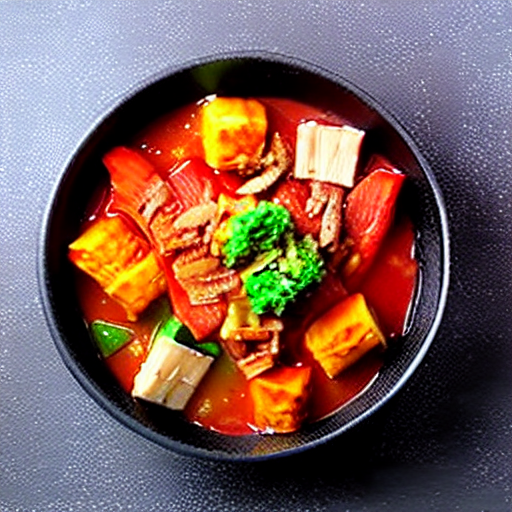

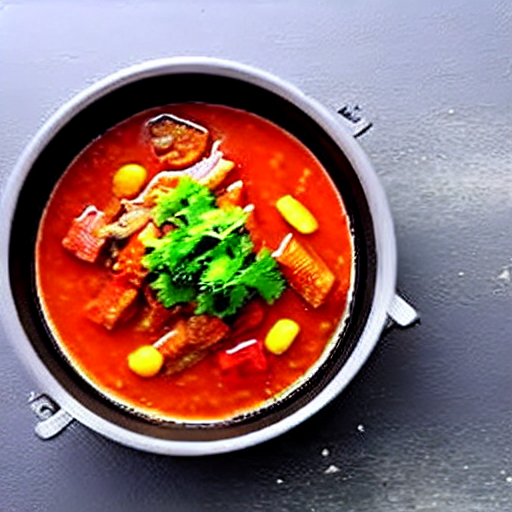

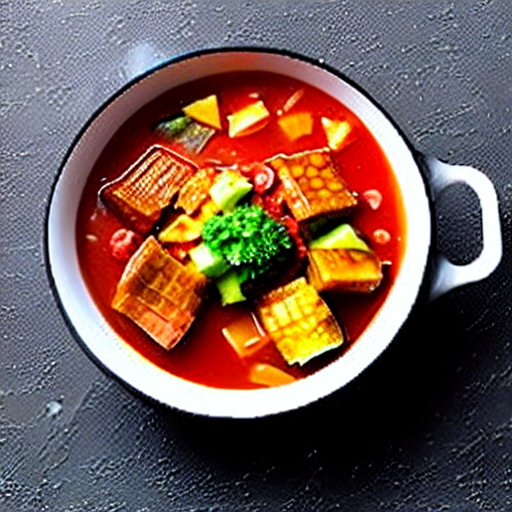

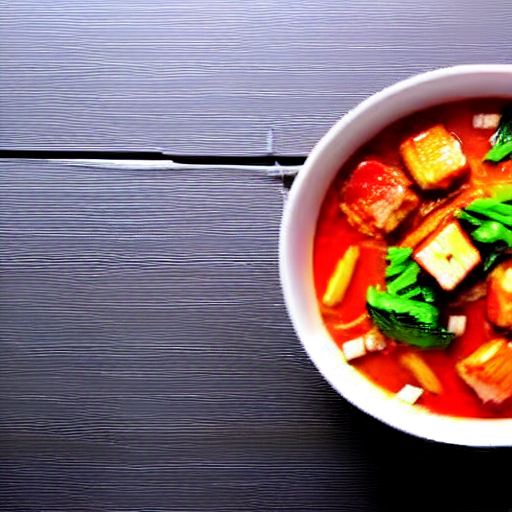

In [10]:
for img in image:
    display(img)

## 이미지 분석용 프롬프트

In [68]:
sys_prompt = (
    "You are an AI advertisement planner.\n"
    "Given a **main product image** and an **optional reference *ad* image**, write a short ad proposal in Korean.\n"
    "The second image is only for *stylistic reference*, not a second product.\n"
    "Explain what kind of background, mood, or layout would fit this product for a local Korean banner ad.\n"
    "Include tone (e.g., warm, luxurious), layout (e.g., product in center), and suggested copy.\n"
    "Keep in mind that this is for stable diffusion v1.5 model."
)

### 인풋 정리, OpenAI 이미지 인식을 위한 base64 처리

In [71]:
product_type = "Korean Food"
marketing_context = "홍보용 광고 배너 제작"

product_base64 = encode_image(product_image_path)
reference_base64 = encode_image(reference_image_path) if reference_image_path else None

### 이미지 및 테마 & 목적 parse

In [72]:
user_prompt = [
    {"type": "text", "text": (
        f"Product type: {product_type}. Context: {marketing_context}.\n"
        "The second image, if present, is a visual reference for ad style, not another product."
    )},
    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{product_base64}"}}
] + (
    [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{reference_base64}"}}]
    if reference_base64 else []
)

In [73]:
message = [
    {
        "role": "system",
        "content": sys_prompt
    },
    {
        "role": "user",
        "content": user_prompt
    }
]

In [74]:
response = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=message,
    max_tokens=300
)

In [75]:
ad_desc = response.choices[0].message.content.strip()
ad_desc

'제안드리는 광고 배너 기획안은 다음과 같습니다.\n\n- 톤: 따뜻하고 진한 맛을 강조하는 진솔하고 정감 가는 분위기\n- 레이아웃: 중앙에 뚝배기 된장찌개 또는 김치찌개 같은 한국 전통 찌개를 클로즈업으로 배치하고, 배경은 따뜻한 나무 식탁 또는 한옥 느낌의 배경을 흐리게 처리하여 음식이 돋보이도록 연출\n- 배경: 따뜻한 주황빛 조명 또는 자연광을 활용해 음식의 붉은 국물 색감과 재료의 신선함을 살림. 배경은 부담스럽지 않은 미니멀리즘으로 음식에 집중\n- 카피 문구 예시:\n  - "정성이 담긴 한 그릇, 집밥 같은 깊은 맛"\n  - "한국의 맛을 집에서, 진한 국물 맛 그대로"\n  - "따끈한 찌개 한 그릇, 몸과 마음을 채우다"\n\n이 배너는 제품의 맛과 정통성을 강조하며 한식의 편안함과 건강함을 소비자에게 전달하는 데 효과적일 것입니다. 이미지 중앙에 국물이 진하고 풍성한 찌개를 크게 배치해 시선을 사로잡고, 둥근 형태가 주는 따'

In [101]:
ad_prompt = (
    "You're an assistant that converts ad ideas into short Stable Diffusion v1.5 prompts.\n"
    "Summarize the style, mood, and layout from the Korean ad suggestion below.\n"
    "Output a 1-sentence English prompt within 77 CLIP tokens, suitable for clean commercial backgrounds.\n"
    "Exclude any product names, text, or brand mentions."
    "If the prompt is for the food, generated image should be with empty plate or bowl. "
    "else, requires placeholder for product"
    "Keep in mind that this prompt must be simple and straight forward in order to pass it to stable diffusion v1.5 model"
)

In [102]:
ad_message = [
    {
        "role": "system",
        "content": ad_prompt
    },
    {
        "role": "user",
        "content": ad_desc
    }
]

In [103]:
back_response = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=ad_message,
    max_tokens=77
)

In [104]:
sd_prompt = back_response.choices[0].message.content
sd_prompt

'Warm and rich Korean stew close-up centered on a clean empty bowl, blurred traditional wooden or hanok-style background with soft orange natural lighting, minimalist and cozy atmosphere emphasizing comfort and authenticity.'

In [105]:
ad_gen_img = pipe(
    prompt=sd_prompt,
    height=768,
    width=432
    )

 14%|█▍        | 7/50 [00:00<00:03, 11.41it/s]

100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


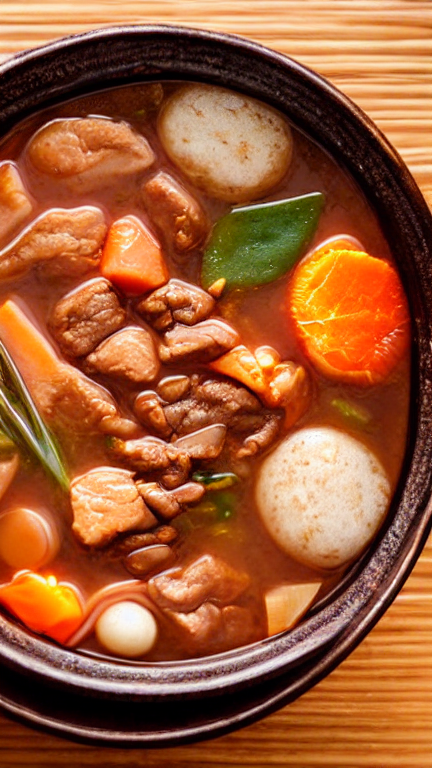

In [106]:
ad_gen_img.images[0]

In [98]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# 모델 준비
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 카테고리 후보
candidate_categories = [
    "Korean food", "Japanese food", "Chinese food", "Western food",
    "cosmetics", "shoes", "handbag", "jewelry", "smartphone", "snack", "beverage"
]

# 예측 함수
def predict_product_category(image_path: str, candidates=candidate_categories) -> str:
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=candidates, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1)
        return candidates[probs.argmax().item()]

# 사용 예시
product_image_path = "./images/food1.jfif"
product_type = predict_product_category(product_image_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [25]:
product_type

'Korean food'

In [184]:
import os

os.listdir("./lora")

['meishi.safetensors',
 'foodplatters.safetensors',
 'fodm4st3r.safetensors',
 'product_design_v3.safetensors',
 'e-commerce_photography02.safetensors',
 'FoodPorn_v2.safetensors',
 'showcase.safetensors']